In [19]:
import json
import numpy as np
node_dict = {}
with open("san_francisco_censustracts.json") as jsondata:
    d = json.load(jsondata)
    for feature in d["features"]:
        if feature["properties"]["DISPLAY_NAME"] == "100 Campus Drive, Stanford":
            print("Stanford", feature["properties"]["MOVEMENT_ID"])
        if feature["properties"]["DISPLAY_NAME"] == "700 Meder Street, Santa Cruz":
            print("UCSC", feature["properties"]["MOVEMENT_ID"])
        data = feature["geometry"]["coordinates"][0][0]
        c1= []
        c2 = []
        for d in data:
            c1.append(d[0])
            c2.append(d[1])
        node_dict[int(feature["properties"]["MOVEMENT_ID"])] = [np.mean(c1), np.mean(c2)]

('UCSC', u'1968')
('Stanford', u'2607')


In [20]:
print(node_dict[1968])
print(node_dict[2607])

[-122.0645618108108, 36.974168810810809]
[-122.17598222222222, 37.429685888888891]


In [2]:
from scipy.spatial import Delaunay
import numpy as np
# print(node_dict.values())

In [3]:
# stanford_nodes = stanford_nodes[0][0]
# ucsc_nodes = ucsc_nodes[0][0]

# nodes = []
# for node in stanford_nodes:
#     nodes.append(node)
# for node in ucsc_nodes:
#     nodes.append(node)
points = np.array(list(node_dict.values()))

In [4]:
print(len(points))

2710


In [26]:
print(points[1967])
print(points[2606])

[-122.06456181   36.97416881]
[-122.17598222   37.42968589]


In [5]:
tri = Delaunay(points)

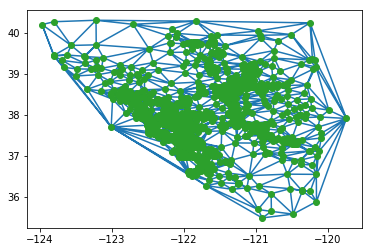

In [6]:
import matplotlib.pyplot as plt
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.show()

In [7]:
print(tri.vertices[1])

[204 247 629]


In [8]:
edges = set() 
for n in range(tri.nsimplex): 
    edge = ([tri.vertices[n,0], tri.vertices[n,1]]) 
    if edge[0] in node_dict and edge[1] in node_dict:
        edges.add((edge[0], edge[1])) 
    edge = ([tri.vertices[n,0], tri.vertices[n,2]]) 
    if edge[0] in node_dict and edge[1] in node_dict:
        edges.add((edge[0], edge[1])) 
    edge = ([tri.vertices[n,1], tri.vertices[n,2]])     
    if edge[0] in node_dict and edge[1] in node_dict:
        edges.add((edge[0], edge[1])) 
# print(edges)

In [9]:
import csv
speed_dict = {}
with open('san_francisco-censustracts-2017-4-All-MonthlyAggregate.csv') as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    next(csvReader, None)
    for row in csvReader:
        if row[2] == "12":
            keypair = (int(row[0]), int(row[1]))
            if keypair in speed_dict:
                speed_dict[keypair].append(float(row[3]))
            speed_dict[keypair] = [float(row[3])]


In [10]:
for key, value in zip(speed_dict.keys(), speed_dict.values()):
    speed_dict[key] = np.mean(value)

In [11]:
traffic_flows = {}
filtered_edges = []
filtered_points = []
for i in range(len(edges)):
    edge = list(edges)[i]
#     start = points[edge[0]]
#     end = points[edge[1]]
    start = node_dict[edge[0]]
    end = node_dict[edge[1]]
    key1 = (edge[0],edge[1])
    if key1 in speed_dict:
        filtered_edges.append(edge)
        filtered_points.append(node_dict[edge[0]])
        filtered_points.append(node_dict[edge[1]])
        road_len = np.sqrt(np.power(end[1] - end[0], 2) + np.power(start[1] - start[0], 2)) * 69.0
        speed = road_len/speed_dict[key1]
#         road_len = np.sqrt(np.power(end[1] - end[0], 2) + np.power(start[1] - start[0], 2)) * 69.0
    #     traffic_flow = 4*(road_len / (0.003 + (60 * 2)/3600.0))
        traffic_flow = speed * (1/(0.003 + (speed * 2)/3600.0))
        traffic_flows[edge] = traffic_flow
        print("For road: ", edge, " the traffic flow is: ", traffic_flow)



('For road: ', (1617, 1608), ' the traffic flow is: ', 1437.7735434919221)
('For road: ', (1586, 1098), ' the traffic flow is: ', 1342.9695511837106)
('For road: ', (1932, 1934), ' the traffic flow is: ', 1480.3668818107674)
('For road: ', (1558, 322), ' the traffic flow is: ', 932.06601000792705)
('For road: ', (2146, 547), ' the traffic flow is: ', 1395.5905921536191)
('For road: ', (1064, 1538), ' the traffic flow is: ', 1639.8951729821317)
('For road: ', (2435, 1081), ' the traffic flow is: ', 1341.7787576768596)
('For road: ', (1755, 2247), ' the traffic flow is: ', 1692.5268597372012)
('For road: ', (1245, 642), ' the traffic flow is: ', 1553.2559503897339)
('For road: ', (1807, 1805), ' the traffic flow is: ', 1528.6973578853958)
('For road: ', (2422, 1584), ' the traffic flow is: ', 1522.6739321170137)
('For road: ', (2420, 2213), ' the traffic flow is: ', 1060.5383858602736)
('For road: ', (660, 2613), ' the traffic flow is: ', 1119.1225061059447)
('For road: ', (2225, 2519), 

('For road: ', (641, 1689), ' the traffic flow is: ', 1506.2771185690258)
('For road: ', (1526, 2434), ' the traffic flow is: ', 1537.9204349708973)
('For road: ', (81, 650), ' the traffic flow is: ', 1422.6391336899956)
('For road: ', (2394, 63), ' the traffic flow is: ', 1401.2627067671519)
('For road: ', (1705, 2316), ' the traffic flow is: ', 1499.2924772060394)
('For road: ', (683, 1754), ' the traffic flow is: ', 1554.832344323378)
('For road: ', (840, 295), ' the traffic flow is: ', 1742.4372034039618)
('For road: ', (1447, 1448), ' the traffic flow is: ', 1690.8916643803827)
('For road: ', (1936, 556), ' the traffic flow is: ', 1239.9462146695489)
('For road: ', (458, 1081), ' the traffic flow is: ', 1406.7650119563457)
('For road: ', (1884, 1888), ' the traffic flow is: ', 1571.3196294477611)
('For road: ', (720, 555), ' the traffic flow is: ', 1422.7809570685774)
('For road: ', (918, 555), ' the traffic flow is: ', 1258.3210210722852)
('For road: ', (91, 187), ' the traffic f

('For road: ', (1889, 1891), ' the traffic flow is: ', 1457.2900679612776)
('For road: ', (2469, 2060), ' the traffic flow is: ', 1597.140726540581)
('For road: ', (1908, 1564), ' the traffic flow is: ', 1429.3131382813756)
('For road: ', (1649, 1770), ' the traffic flow is: ', 1542.3805425301821)
('For road: ', (1689, 1244), ' the traffic flow is: ', 1660.1678433355246)
('For road: ', (446, 1094), ' the traffic flow is: ', 1237.1178162944607)
('For road: ', (1904, 1903), ' the traffic flow is: ', 1544.3891360546695)
('For road: ', (1309, 722), ' the traffic flow is: ', 1725.8813304328107)
('For road: ', (2197, 1598), ' the traffic flow is: ', 1427.7234667135001)
('For road: ', (598, 1062), ' the traffic flow is: ', 1327.5997338572913)
('For road: ', (800, 2025), ' the traffic flow is: ', 1661.355227644576)
('For road: ', (1450, 1451), ' the traffic flow is: ', 1685.7687957170178)
('For road: ', (1778, 2322), ' the traffic flow is: ', 1170.0719339565239)
('For road: ', (1040, 1623), ' 

('For road: ', (1808, 1154), ' the traffic flow is: ', 1210.6090341838271)
('For road: ', (1771, 1293), ' the traffic flow is: ', 1706.1441299424155)
('For road: ', (1294, 80), ' the traffic flow is: ', 1371.7357779267463)
('For road: ', (1969, 1968), ' the traffic flow is: ', 1470.3949983927398)
('For road: ', (1640, 1641), ' the traffic flow is: ', 1437.9811292516908)
('For road: ', (386, 1097), ' the traffic flow is: ', 1325.2111469305019)
('For road: ', (1704, 651), ' the traffic flow is: ', 1713.6672689918239)
('For road: ', (866, 2311), ' the traffic flow is: ', 1643.7001554215117)
('For road: ', (1695, 1293), ' the traffic flow is: ', 1179.2806634802123)
('For road: ', (1173, 2123), ' the traffic flow is: ', 1472.6452425978614)
('For road: ', (568, 1398), ' the traffic flow is: ', 1263.5246895289249)
('For road: ', (1833, 344), ' the traffic flow is: ', 918.04286940974612)
('For road: ', (1081, 1059), ' the traffic flow is: ', 1263.0812020983601)
('For road: ', (542, 2504), ' th

('For road: ', (2244, 1750), ' the traffic flow is: ', 1732.8020054415156)
('For road: ', (1921, 695), ' the traffic flow is: ', 1589.9073701845166)
('For road: ', (1941, 700), ' the traffic flow is: ', 1318.1269067930755)
('For road: ', (154, 739), ' the traffic flow is: ', 1693.1460299479004)
('For road: ', (1697, 650), ' the traffic flow is: ', 1330.6164464448432)
('For road: ', (596, 1071), ' the traffic flow is: ', 1643.2195352365645)
('For road: ', (1648, 2320), ' the traffic flow is: ', 1209.7519662373641)
('For road: ', (221, 815), ' the traffic flow is: ', 1156.5228815316857)
('For road: ', (697, 390), ' the traffic flow is: ', 1493.1605896674885)
('For road: ', (1114, 241), ' the traffic flow is: ', 1643.6202092834169)
('For road: ', (233, 1446), ' the traffic flow is: ', 1366.0542111007894)
('For road: ', (1308, 721), ' the traffic flow is: ', 1484.0540133746674)
('For road: ', (1929, 1931), ' the traffic flow is: ', 1574.4183210715983)
('For road: ', (98, 2435), ' the traff

In [12]:
import networkx as nx 
graph1 = nx.Graph(list(edges)) 
graph2 = nx.Graph(list(filtered_edges)) 
# print(graph.edges()) 

# largest_g1 = max(nx.connected_component_subgraphs(graph1), key=len)
# graphs_1 = list(nx.connected_component_subgraphs(graph1))
# print(len(graphs_1))
# graphs_2 = list(nx.connected_component_subgraphs(graph2))
# print(len(graphs_2))
largest_g2 = max(nx.connected_component_subgraphs(graph2), key=len)

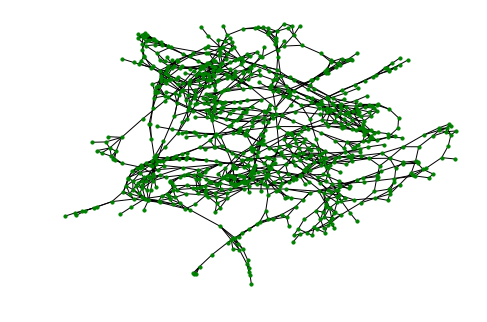

In [13]:
import matplotlib.pyplot as plt 
# pointIDXY = dict(zip(range(len(points)), points)) 
# pointIDXY = dict(zip(range(len(largest_g1.nodes)), largest_g1.nodes))
# nx.draw(graph1,node_size = 10, node_color = "blue") 
# plt.show() 

# pointIDXY = dict(zip(range(len(filtered_points)), filtered_points)) 
nx.draw(largest_g2,node_size = 10, node_color = "green") 
plt.show()

In [14]:
nx.set_edge_attributes(largest_g2, traffic_flows, 'capacity')

In [15]:
print(len(edges))

10810


In [31]:
for (u,v) in largest_g2.edges:
    print(u,v)
    print(largest_g2[u][v])
    if v!=643: break

(8, 643)
{'capacity': 882.61694497818689}
(20, 905)
{'capacity': 1676.4898824012173}


#### Q13 Calculate the Max Flow & Calculate the Number of Edge-Disjoint Paths


In [37]:
stanford_id = 643
UCSC_id = 905
print(nx.maximum_flow_value(largest_g2, stanford_id, UCSC_id))

from networkx.algorithms.connectivity.disjoint_paths import edge_disjoint_paths
print(len(list(edge_disjoint_paths(largest_g2, stanford_id, UCSC_id))))

3768.97596655
3


#### Q14 Defoliate the Graph

In [ ]:
threshold = 20
ebunch = []
for (u,v) in largest_g2.edges():
    if largest_g2[u][v]['weight'] < threshold:
        ebunch.append((u,v))
        
largest_g2.remove_edges_from(ebunch)
# largest_g2.__dict__
# plot on real map coordinates and check bridges location

#### Q15: triangle inequality